In [1]:
import torch
import numpy as np
import sys
import os
from pathlib import Path
import pyvista as pv
import scipy.sparse as sp
import pyamg

if Path.cwd().as_posix().endswith('/collocation_01'):
    os.chdir('../..')
from gnp import GeometryEstimator

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
pv.set_jupyter_backend("static")

In [2]:
def get_data(data_name, noise_level=0.0, noise_ratio=0.0):
    data_path = os.path.join('example_data', data_name)
    data = {}
    for file in os.listdir(data_path):
        if file.endswith('.npy'):
            data[file[:-4]] = torch.from_numpy(np.load(os.path.join(data_path, file))).to(device)
    if noise_level > 0.0 and noise_ratio > 0.0:
        xyz = data['xyz']
        noise_inds = torch.randperm(xyz.shape[0])[:int(noise_ratio*xyz.shape[0])]
        noise = torch.randn_like(xyz[noise_inds]) * noise_level
        xyz[noise_inds] += noise
        data['xyz'] = xyz
    return data

In [3]:
data = get_data('spot')

In [4]:
estimator = GeometryEstimator(pcd=data['xyz'], 
                              orientation=data['normals'], 
                              model='clean_50k',
                              device=device)

In [5]:
stiffness = estimator.stiffness_matrix_gmls(drop_ratio=0.1)

782it [14:42,  1.13s/it]


In [6]:
ls_stiffness = stiffness.T @ stiffness

In [7]:
ml = pyamg.smoothed_aggregation_solver(ls_stiffness,
                                       symmetry='symmetric',
                                       max_levels=5,
                                       coarse_solver='jacobi',
                                       strength=None,
                                       max_coarse=10)
print(ml)
precondtioner = ml.aspreconditioner(cycle='W')

MultilevelSolver
Number of Levels:     3
Operator Complexity:   1.000
Grid Complexity:       1.003
Coarse Solver:        'jacobi'
  level   unknowns     nonzeros
     0       90000     17799350 [99.97%]
     1         255         5525 [0.03%]
     2           8           60 [0.00%]



In [8]:
collocation_mask = estimator.data['stiffness_mask'].cpu().numpy()

In [9]:
solution = data['solutions'][:, 2].cpu().numpy()
source = data['sources'][:, 2].cpu().numpy()

In [10]:
residuals = []
def report_callback(sol_vec):
    source_error = (np.linalg.norm((stiffness @ sol_vec - source)) 
                    / np.linalg.norm(source))
    sol_residual = np.linalg.norm(sol_vec - solution[collocation_mask]) / np.linalg.norm(solution[collocation_mask])
    residuals.append(sol_residual)
    if len(residuals) % 10 == 0:
        print(f'Iteration {len(residuals)} Solution Error: {sol_residual:.3e}, Source Error: {source_error:.3e}')


output = sp.linalg.lgmres(A=ls_stiffness,
                          b=stiffness.T @ source,
                          M=precondtioner,
                          rtol=1e-5,
                          atol=0,
                          maxiter=100,
                          callback=report_callback)
pred = output[0]
pred -= pred.mean()

error = np.linalg.norm(pred - solution[collocation_mask]) / np.linalg.norm(solution[collocation_mask])
print(f'Final Solution Error: {error:.3e}')

Iteration 10 Solution Error: 1.227e-01, Source Error: 3.673e-03
Iteration 20 Solution Error: 8.178e-02, Source Error: 3.481e-03
Iteration 30 Solution Error: 7.496e-02, Source Error: 3.475e-03
Iteration 40 Solution Error: 1.010e-01, Source Error: 3.485e-03
Iteration 50 Solution Error: 8.055e-02, Source Error: 3.476e-03
Iteration 60 Solution Error: 1.046e-01, Source Error: 3.479e-03
Iteration 70 Solution Error: 9.105e-02, Source Error: 3.475e-03
Iteration 80 Solution Error: 1.069e-01, Source Error: 3.479e-03
Iteration 90 Solution Error: 8.104e-02, Source Error: 3.474e-03
Iteration 100 Solution Error: 7.241e-02, Source Error: 3.474e-03
Final Solution Error: 7.180e-02


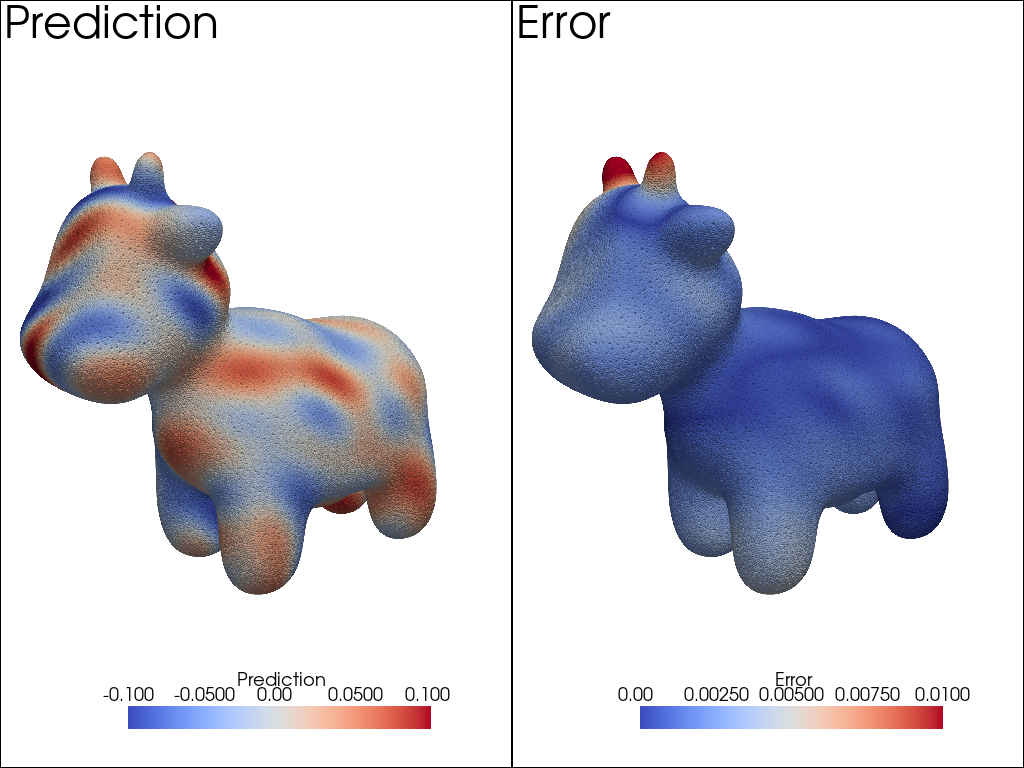

In [12]:
pv_data = pv.PolyData(data['xyz'].cpu().numpy()[collocation_mask])
pv_data['Prediction'] = pred
pv_data['Error'] = np.abs(pred - solution[collocation_mask])

camera_position = [(-5.540426247912693, 1.6662489557744946, -3.5168265303256296),
                   (-0.05816924426784502, 0.08683893634845968, 0.05411275262662977),
                   (0.16073463828406648, 0.9700217471130059, 0.1822695426655861)]
scalar_bar_args = dict(position_x=0.25)

pl = pv.Plotter(shape=(1, 2))
pl.subplot(0, 0)
pl.add_text('Prediction', font_size=18)
pl.add_points(pv_data, 
              point_size=6,
              render_points_as_spheres=True,
              scalars='Prediction', 
              clim=[-0.1, 0.1],
              cmap='coolwarm',
              scalar_bar_args=scalar_bar_args)
pl.camera_position = camera_position
pl.camera.zoom(0.65)
pl.subplot(0, 1)
pl.add_text('Error', font_size=18)
pl.add_points(pv_data,
              point_size=6,
              render_points_as_spheres=True, 
              scalars='Error', 
              cmap='coolwarm', 
              clim=[0, 0.01],
              copy_mesh=True,
              scalar_bar_args=scalar_bar_args)
pl.camera_position = camera_position
pl.camera.zoom(0.65)
pl.show()